# Modeling Assignment
#### Dongzhe Zhang
#### davidzhang647@gmail.com

In [126]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

In [127]:
# load dataset and make a copy
df_original = pd.read_csv('data/hotel_bookings.csv')
df = df_original.copy()

# find the shape of the dataframe
print(df.shape)

(119390, 32)


In [128]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [129]:
# check the data type of each column
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

From the data type, some int64 features are categorical variables.

## Data Preprocessing

### Dealing with NaN

First, check the corraltion between each feature and label to find which numerical features are important:

In [130]:
cancel_corr = df.corr()["is_canceled"]
print(cancel_corr.abs().sort_values(ascending=False)[1:])

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64


Check whether there are dupilicated rows:

In [131]:
rm = df[df.duplicated()]

Then, let us check the missing values:

In [132]:
# print the percentage of NaN for each column
na_precentage = df.isna().sum() / len(df) * 100
print(na_precentage[na_precentage > 0].sort_values(ascending=False))

company     94.306893
agent       13.686238
country      0.408744
children     0.003350
dtype: float64


In [133]:
# check the number of categories and missing values for company column
print(df['company'].notnull().sum())
print(df['company'].nunique())

6797
352


In company column, only 4.69% records are not missing. The correlation between company and label column is low. And there are 352 categories among 6796 non-missing values. The NaN may mean that the company is not in their list. It is very hard to predict, so in feature engineering section below, we just make a new dummy column about whether the company is in the list and delect the company column.

In [134]:
# check the number of categories agent column
print(df['agent'].nunique())

333


In agent column, 13.68% records are missing values. The correlation between agent and label are relative high. There are 333 unique agent. So it may not be predictable. The NaN may mean their agent are not in the list. I will decide how to deal with this column in feature engineering section.

In [135]:
# check the number of categories agent column
print(df['country'].nunique())

177


In country column, only 0.4% are missing. Since there are 177 unique categories, it is hard to predict. It will not a problem to drop this column. I will decide it in the feature engineering section.

In [136]:
# check the cross table of childrend and is_canceled columns
print(pd.crosstab(df['children'], df['is_canceled']))

is_canceled      0      1
children                 
0.0          69702  41094
1.0           3294   1567
2.0           2111   1541
3.0             59     17
10.0             0      1


In this dataset, there are only 4 missing values in children column. The correlation between children and label columns is low. From the crosstable, we see most records have 0 child. So we use 0 instead the NaN. A hotel room with 10 children is a outlier so we delete that record.

In [137]:
# use 0 instead of NaN
df['children'] = df['children'].fillna(0)

# drop the record has 10 children
df.drop(df[df.children == 10].index, axis=0, inplace=True)

df.shape

(119389, 32)

### Checking outliers

In [138]:
df_original.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


From the describe statistic, I will check outliers in the following numeric features:
*  lead_time
*  stays_in_weekend_nights, stays_in_week_nights
*  adults, children, babies
*  previous_cancellations, previous_bookings_not_canceled, booking changes
*  adr

(3005, 32)


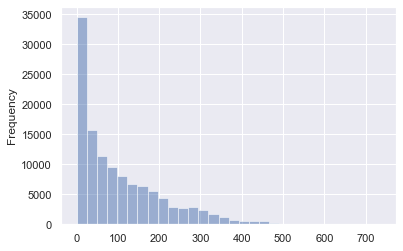

In [139]:
df_original.lead_time.plot.hist(bins=30, alpha=0.5)
print(df_original[df_original.lead_time>160+(160-18)*1.5].shape)

For lead_time column, the records over Q3+1.5*IQR seem make sence. Some rooms are booked in advance 12-18 month. It makes sence and there is no extrame values. So I think there is no outlier.

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
14038,Resort Hotel,0,126,2016,July,28,5,19,50,1,...,No Deposit,NaN,NaN,0,Transient,110.0,0,3,Check-Out,2016-09-12


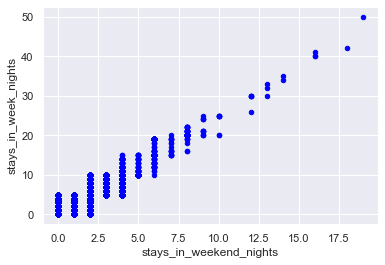

In [140]:
df_original.plot.scatter(x = 'stays_in_weekend_nights',
                         y = 'stays_in_week_nights', c='blue')
df_original[df_original.stays_in_weekend_nights == 19]

The record that has stayed 19 weekend_nights and 50 stays_in_week_nights make sence (10 weeks). That is not a outlier

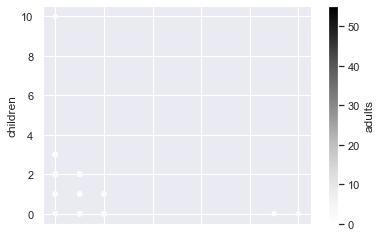

In [141]:
df_original.plot.scatter(x = 'babies',
                         y = 'children', c='adults')

In [142]:
print(df_original[df_original.babies > 3][['is_canceled','adr','adults', 'babies', 'children']])
print(df_original[df_original.children > 3][['is_canceled','adr','adults', 'babies', 'children']])
print(df_original[df_original.adults > 5][['is_canceled','adr','adults', 'babies', 'children']])

       is_canceled    adr  adults  babies  children
46619            0  84.45       2      10       0.0
78656            0  95.00       1       9       0.0
     is_canceled     adr  adults  babies  children
328            1  133.16       2       0      10.0
      is_canceled  adr  adults  babies  children
1539            1  0.0      40       0       0.0
1587            1  0.0      26       0       0.0
1643            1  0.0      50       0       0.0
1752            1  0.0      26       0       0.0
1884            1  0.0      26       0       0.0
1917            1  0.0      27       0       0.0
1962            1  0.0      27       0       0.0
2003            1  0.0      26       0       0.0
2164            1  0.0      26       0       0.0
2173            1  0.0      55       0       0.0
2228            1  0.0      20       0       0.0
2229            1  0.0       6       0       0.0
2417            1  0.0      10       0       0.0
2418            1  0.0      20       0       0.0


For the first three records, it is highly possible that 1 or 2 adults with 9 or 10 children would be typos. Also, the room rates indicate these are not suites or large rooms. 

For the rest of records, all records are canceled and the room rate is 0. It is obviously these records are outilers

In [143]:
df.drop(df[df_original.babies > 3].index, inplace=True)
df.drop(df[df_original.children > 3].index, inplace=True)
df.drop(df[df_original.adults > 5].index, inplace=True)

E:\anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
E:\anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
E:\anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
15083,Resort Hotel,0,1,2015,July,29,15,0,1,2,...,No Deposit,NaN,NaN,0,Transient,508.0,1,0,Check-Out,2015-07-16
48515,City Hotel,1,35,2016,March,13,25,0,1,2,...,Non Refund,12.0,NaN,0,Transient,5400.0,0,0,Canceled,2016-02-19
111403,City Hotel,0,0,2017,May,19,9,0,1,1,...,No Deposit,159.0,NaN,0,Transient,510.0,0,0,Check-Out,2017-05-10


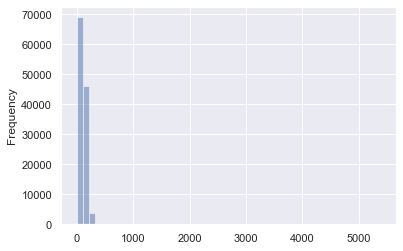

In [144]:
df_original.adr.plot.hist(bins=50, alpha=0.5)
df_original[df_original.adr>500]

The record with adr = 5400 is a outiler, so we will delete it.

In [145]:
df.drop(df[df_original.adr == 5400].index, inplace=True)

E:\anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [146]:
drop_index = []
drop_index.append(df[df_original.children > 3].index)
drop_index

E:\anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


[Int64Index([], dtype='int64')]

## Feature Engineering

From last section, we make a new dummy column about whether the company is in the list and delect the company column.

In [147]:
# create a new column, return 1 if the company is not null
df['company_listed'] = df['company'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [148]:
df.drop(['company'], axis=1, inplace=True)

Since arrival_date_year, arrival_date_month, arrival_date_day and lead_time already cover all information of reservation_status_date. So we just delete reservation_status_date here. 

In [149]:
df.drop(['reservation_status_date'], axis=1, inplace=True)

Also, we drop reservation_status since we cannot use result to predict cancellation:

In [150]:
df.drop(['reservation_status'], axis=1, inplace=True)

For calculating correlation and feature selection, here I use LabelEncoder to transform non-numerical columns to numerical labels:

In [151]:
# copy the data for LabelEncoder
df_enc = df.copy()
enc = LabelEncoder()

In [152]:
# for each column, if the data type is object, apply LabelEncoder
for column in df_enc.loc[:, df_enc.dtypes == object]:
    df_enc[column] = enc.fit_transform(df_enc[column].astype(str))

In [153]:
df_enc

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,company_listed
0,1,0,342,2015,5,27,1,0,0,2,...,2,3,0,NaN,0,2,0.00,0,0,0
1,1,0,737,2015,5,27,1,0,0,2,...,2,4,0,NaN,0,2,0.00,0,0,0
2,1,0,7,2015,5,27,1,0,1,1,...,2,0,0,NaN,0,2,75.00,0,0,0
3,1,0,13,2015,5,27,1,0,1,1,...,0,0,0,304.0,0,2,75.00,0,0,0
4,1,0,14,2015,5,27,1,0,2,2,...,0,0,0,240.0,0,2,98.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,0,23,2017,1,35,30,2,5,2,...,0,0,0,394.0,0,2,96.14,0,0,0
119386,0,0,102,2017,1,35,31,2,5,3,...,4,0,0,9.0,0,2,225.43,0,2,0
119387,0,0,34,2017,1,35,31,2,5,2,...,3,0,0,9.0,0,2,157.71,0,4,0
119388,0,0,109,2017,1,35,31,2,5,2,...,0,0,0,89.0,0,2,104.40,0,0,0


In [154]:
# print the correlation between label column and each feature
df_corr = df_enc.corr()["is_canceled"].abs().sort_values(ascending=False)
print(df_corr)

is_canceled                       1.000000
deposit_type                      0.468735
lead_time                         0.292910
country                           0.264111
total_of_special_requests         0.234583
required_car_parking_spaces       0.195481
assigned_room_type                0.176029
distribution_channel              0.167768
booking_changes                   0.144399
hotel                             0.136797
previous_cancellations            0.110163
company_listed                    0.099282
is_repeated_guest                 0.084774
agent                             0.083113
customer_type                     0.067816
adults                            0.063078
reserved_room_type                0.061297
market_segment                    0.059488
previous_bookings_not_canceled    0.057350
days_in_waiting_list              0.054214
adr                               0.049040
babies                            0.034062
stays_in_week_nights              0.024610
meal       

### Feature Selection

First, we remove Quasi constant features by applying threshold=0.1

In [155]:
sel = VarianceThreshold(threshold=0.1)
sel.fit(df_enc)

VarianceThreshold(threshold=0.1)

In [156]:
df_enc.shape

(119372, 30)

There is no Quasi constant features. Then we try to remove highly correlated features:

In [157]:
# build a dataframe with the correlation between features
# remember that the absolute value of the correlation
# coefficient is important and not the sign

corrmat = df_enc.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[(corrmat <1)& (corrmat > 0.8)]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat

,feature1,feature2,corr
0,reserved_room_type,assigned_room_type,0.813986
1,assigned_room_type,reserved_room_type,0.813986


From the dataframe, there are two pairs of features highly correlated: reserved_room_type and assigned_room_type.Here we remove the feature has lower correlation with label in each pair: **reserved_room_type**.

Also, we remove the features that the correlation with label are smaller than 0.005: **arrival_date_month**, **stays_in_weekend_nights** and **children**

In [158]:
# remove these columns from the dataframe
df.drop(columns = ['arrival_date_year', 'reserved_room_type', 'arrival_date_month',
                  'stays_in_weekend_nights', 'children'],
        axis=1, inplace=True)

Columns agent and country still have missing values. Since they are categorical variables, we just use 'not provided' to fill with NaN

In [159]:
# fill the missing values
df['agent'] = df['agent'].fillna('not provided')
df['country'] = df['country'].fillna('not provided')

# check the number of NaN again
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_week_nights              0
adults                            0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
company_listed                    0
dtype: int64

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119372 entries, 0 to 119389
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119372 non-null  object 
 1   is_canceled                     119372 non-null  int64  
 2   lead_time                       119372 non-null  int64  
 3   arrival_date_week_number        119372 non-null  int64  
 4   arrival_date_day_of_month       119372 non-null  int64  
 5   stays_in_week_nights            119372 non-null  int64  
 6   adults                          119372 non-null  int64  
 7   babies                          119372 non-null  int64  
 8   meal                            119372 non-null  object 
 9   country                         119372 non-null  object 
 10  market_segment                  119372 non-null  object 
 11  distribution_channel            119372 non-null  object 
 12  is_repeated_gues

### Convert string columns to numerical 

Before converting, we find the numerical columns:

In [161]:
numerical_col = []
for column in df.loc[:, df.dtypes != object]:
    numerical_col.append(column)

print(numerical_col)

['is_canceled', 'lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_week_nights', 'adults', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'company_listed']


For country and agent, there are more than 300 unique value in each feature. So I use label encoder here:

In [162]:
df['country'] = enc.fit_transform(df['country'].astype(str)) 
df['agent'] = enc.fit_transform(df['agent'].astype(str)) 

For rest of features, I use one hot encoding:

In [163]:
df = pd.get_dummies(data=df, columns=['hotel', 'meal', 'market_segment',
                                     'distribution_channel', 'assigned_room_type',
                                     'deposit_type', 'customer_type'])

In [164]:
df.shape

(119372, 57)

In [165]:
df.columns

Index(['is_canceled', 'lead_time', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_week_nights', 'adults', 'babies',
       'country', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'company_listed', 'hotel_City Hotel',
       'hotel_Resort Hotel', 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC',
       'meal_Undefined', 'market_segment_Aviation',
       'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'market_segment_Undefined', 'distribution_channel_Corporate',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'distribution_channel_Undefined',
       'assigned_room_type_A', 'assigned_room_type_B', 'as

## Modeling

Before modeling, first we split into training and test dataset and standardlize the training set:

In [166]:
y = df['is_canceled']
X = df.drop(["is_canceled"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Here we only want to standardize real numerical data, so we exclude all dummy variables and ordered variables:

In [167]:
col_to_remove = ['is_canceled', 'arrival_date_week_number',
                 'arrival_date_day_of_month', 'is_repeated_guest',
                 'company_listed']
numerical_col = [i for i in numerical_col if i not in col_to_remove]
print(numerical_col)

['lead_time', 'stays_in_week_nights', 'adults', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


In [168]:
# Standardization
scaler = StandardScaler()
scaler.fit(X_train.loc[:, numerical_col])
X_train.loc[:, numerical_col] = scaler.transform(X_train.loc[:, numerical_col])
X_test.loc[:, numerical_col] = scaler.transform(X_test.loc[:, numerical_col])

E:\anaconda\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
E:\anaconda\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Then we will use Logistic Regression, Random Forest and XGBoost then choose the best two models for hyperparameter tuning

### Logistic Regression

In [35]:
model_logistic = LogisticRegression(random_state=0, max_iter=100, n_jobs=-1)
model_logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=0,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [36]:
y_pred_logistic = model_logistic.predict(X_test)

In [38]:
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred_logistic)))

Accuracy Score: 0.7956836139263478


### Random Forest

In [97]:
rf = RandomForestClassifier(n_estimators= 1000, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [98]:
y_pred_rf = rf.predict(X_test)

In [99]:
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred_rf)))

Accuracy Score: 0.8878186336097383


### XGBoost

In [37]:
xgb = XGBClassifier(n_estimators = 500, max_depth=5,
                    objective='binary:logistic',random_state=0)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
y_pred_xgb = xgb.predict(X_test)

In [39]:
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred_xgb)))

Accuracy Score: 0.8722952787782338


### SVM

In [74]:
svc = SVC(C=10, gamma=0.1, max_iter=500, random_state=0)
svc.fit(X_train, y_train)

E:\anaconda\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=500, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [75]:
y_pred_svc = svc.predict(X_test)

In [76]:
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred_svc)))

Accuracy Score: 0.6358991540330011


### 

### Random Forest Model Tuning

In [34]:
rf_parameters = {"max_depth": [7,10,None],
                 "n_estimators": [200,500,1000],
                 "min_samples_split": [2,5]}

In [35]:
rf_model = RandomForestClassifier()
rf_cv_model = GridSearchCV(rf_model,
                           rf_parameters,
                           cv = 10,
                           n_jobs = -1,
                           verbose = 2)

rf_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 15.9min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [36]:
print('Best parameters: ' + str(rf_cv_model.best_params_))

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [51]:
rf_tuned = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

rf_tuned.fit(X_train, y_train)
y_prob_rf_tuned = rf_tuned.predict_proba(X_test)[:,1]
y_pred_rf_tuned = rf_tuned.predict(X_test)
print('AUC: {}'.format(roc_auc_score(y_test, y_prob_rf_tuned)))

AUC: 0.9556401446388143


### XGBoost Model Tuning

In [39]:
xgb_parameters = {"max_depth": [3,5,7],
                 "n_estimators": [200,500,800],
                 "min_samples_split": [2,5]}

In [40]:
xgb_model = XGBClassifier()
xgb_cv_model = GridSearchCV(xgb_model,
                           xgb_parameters,
                           cv = 5, verbose=2,
                           n_jobs = -1)

xgb_cv_model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 7], 'min_samples_split': [2, 5],
                         'n_estimators': [200, 500, 800]},
             pre_dispatch='2*n_jobs', refit=T

In [41]:
print('Best parameters: ' + str(xgb_cv_model.best_params_))

Best parameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 800}


Try other parameter based on the result above:

In [58]:
xgb_parameters2 = {"max_depth": [7,10,13],
                 "n_estimators": [800,1000],
                  "min_samples_split": [2]}

In [ ]:
xgb_model = XGBClassifier()
xgb_cv_model = GridSearchCV(xgb_model,
                           xgb_parameters2,
                           cv = 5, verbose=2,
                           n_jobs = 5)

xgb_cv_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [ ]:
print('Best parameters: ' + str(xgb_cv_model.best_params_))

In [35]:
xgb_tuned = XGBClassifier(max_depth = 10,
                         min_samples_split = 2, n_jobs=-1,
                         n_estimators = 1000, random_state=0)

xgb_tuned.fit(X_train, y_train)
y_prob_xgb_tuned = xgb_tuned.predict_proba(X_test)[:,1]
y_pred_xgb_tuned = xgb_tuned.predict(X_test)
print('AUC: {}'.format(roc_auc_score(y_test, y_prob_xgb_tuned)))

AUC: 0.9563848254331316


## Conclusion

Our best model is: XGBoost

In [37]:
confusion_matrix(y_test,y_pred_xgb_tuned)

array([[20726,  1739],
       [ 2287, 11065]], dtype=int64)

Text(0.5, 0, 'False Positive Rate')

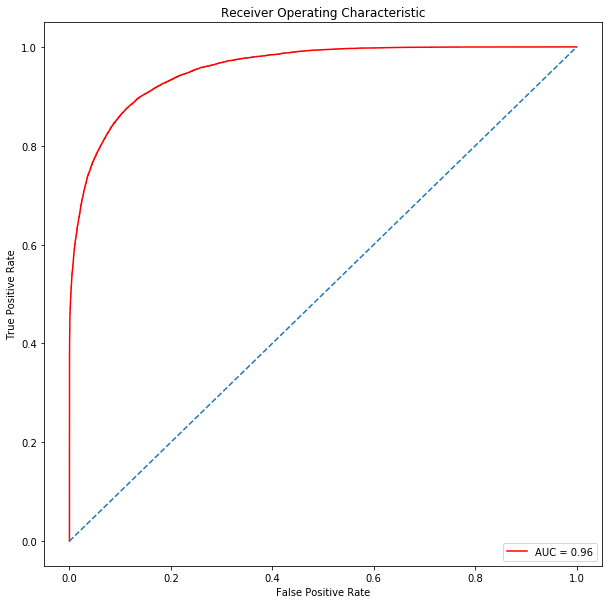

In [38]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob_xgb_tuned)
roc_auc = auc(false_positive_rate, true_positive_rate)
    
plt.figure(figsize = (10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Feature importances:

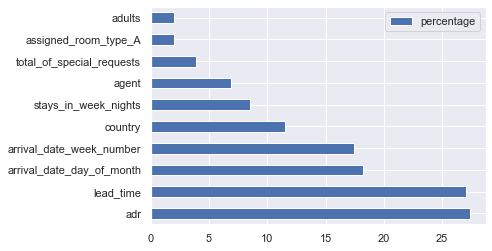

In [194]:
feature_important = xgb_tuned.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(map(float, list(feature_important.values())))
values = [x / (len(df)) * 100 for x in values]

data = pd.DataFrame(data=values, index=keys, columns=["percentage"]).sort_values(by = "percentage", ascending=False)[:10]
data.plot(kind='barh')